In [ ]:
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy as sp

from network_flow_tracker.utils import io
import network_flow_tracker.simulation as sim

%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
data_group = 'Lightfield'
dataset = 'Zhang2020'
data_root_path = f'C:\\Data\\{data_group}\\{dataset}'
process_data_root = os.path.join(data_root_path, 'processed_data')
vis_folder_root = os.path.join(data_root_path, 'visualization')
vis_folder = os.path.join(vis_folder_root, 'simulation')

### Non-interacting free particles in a cylinder

In [2]:
num_p = 100000
R_cyl = 5
num_radial_bin = 10

In [ ]:
ratio_list = np.logspace(-2, 2, 100)
num_para = ratio_list.size
stat_m = {k : np.zeros((num_para, num_radial_bin)) for k in ['r', 'z', 'd']}
stat_se = {k : np.zeros((num_para, num_radial_bin)) for k in ['r', 'z', 'd']}

for i, beta_dfs2dc in enumerate(list(ratio_list)): 
# d_fs_to_R_cyl = 1
    d_fs = beta_dfs2dc * 2 * R_cyl # free space distance
    L_cyl = (num_p * d_fs ** 3 / (np.pi * R_cyl ** 2))
    # print(f"The cylinder of length {L_cyl:.2e} and radius {R_cyl} has {num_p} particles.")
    p_pos = sim.sample_free_particles_in_cylinder(num_p, R_cyl, L_cyl)
    r_val, tmp_stat_m, tmp_stat_std, tmp_stat_se = sim.compute_avg_min_distances(p_pos, R_cyl, num_radial_bin)
    for k in tmp_stat_m.keys():
        stat_m[k][i] = tmp_stat_m[k] / d_fs
        stat_se[k][i] = tmp_stat_se[k] / d_fs

Text(0.5, 1.0, '# particles: 100000, min 0.556')

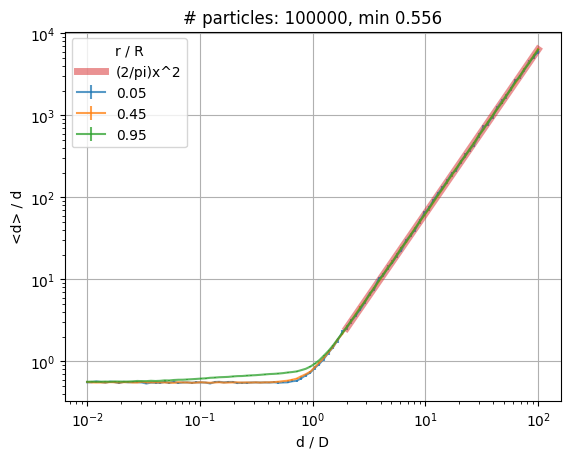

In [124]:
vis_name = 'd'
tmp_m = stat_m[vis_name]
tmp_se = stat_se[vis_name]
tmp_min_ratio = 2

fit_x = ratio_list
fit_y = tmp_m[:, -1].flatten()
fit_selected_Q = fit_x >= tmp_min_ratio
fit_x = fit_x[fit_selected_Q]
fit_y = fit_y[fit_selected_Q]
fit_x_l = np.log10(fit_x)
fit_y_l = np.log10(fit_y)
loglog_fit_result = sp.stats.linregress(fit_x_l, fit_y_l)
fit_A = 10 ** loglog_fit_result.intercept
fit_k = loglog_fit_result.slope
fit_fun = lambda x : fit_A * x ** fit_k
theory_fun = lambda x : 8 / (2 * 2 * np.pi) * x ** 2
fit_vis_x = np.linspace(tmp_min_ratio, ratio_list[-1], 10)
fit_vis_y = theory_fun(fit_vis_x)
f, a = plt.subplots()
for i, v in enumerate(r_val):
    if i in [0, 4, 9]: 
        a.errorbar(ratio_list, tmp_m[:, i].flatten(), 2 * tmp_se[:, i].flatten(), label=f'{v / R_cyl}', alpha=0.75)
    # a.plot(ratio_list, tmp_m[:, -1].flatten(), label='last')
a.plot(fit_vis_x, fit_vis_y, linewidth=5, alpha=0.5, label=f"(2/pi)x^{2}")
a.legend(title='r / R')
a.set_xscale('log')
a.set_yscale('log')
a.set_ylabel('<d> / d')
a.set_xlabel('d / D')
a.grid()

a.set_title(f"# particles: {num_p}, min {tmp_m[0, 0]:.3f}")

In [125]:
0.893 * (3/4/np.pi) ** (1/3)

0.5539729883731643

### Hard spheres in a cylinder

In [32]:
np.log10((4 * np.pi / 0.5 / 3 / 0.2) ** (1/3) / 2)

0.23966620743683

In [3]:
num_p = 100000
num_radial_bin = 10
R_sphere = 2
gamma_list = np.logspace(0, np.log10(50), 15)
beta_list = np.logspace(0.24, np.log10(20), 10)
stat_keys = ['r', 'z', 'd']

hs_r = np.zeros((gamma_list.size, num_radial_bin))
hs_stat_m = {k : np.zeros((gamma_list.size, beta_list.size, num_radial_bin)) for k in stat_keys}
hs_stat_std = {k : np.zeros((gamma_list.size, beta_list.size, num_radial_bin)) for k in stat_keys}
hs_stat_se = {k : np.zeros((gamma_list.size, beta_list.size, num_radial_bin)) for k in stat_keys}

In [ ]:
def run_simulation_safe(i_g, gamma_Rs2Rc, i_b, beta_dfs2dc, R_sphere, num_p, num_radial_bin):
    try:
        import network_flow_tracker.simulation as sim  # Local import for safety with multiprocessing

        R_cyl = gamma_Rs2Rc * R_sphere 
        R_cyl = R_cyl + 1e-6 if np.abs(gamma_Rs2Rc - 1) < 1e-6 else R_cyl

        if np.abs(gamma_Rs2Rc - 1) < 0.05 and np.abs((beta_dfs2dc / gamma_Rs2Rc) - 1) < 0.05:
            return (i_g, i_b, 'skipped', None)

        d_fs = beta_dfs2dc * 2 * R_sphere
        L_cyl = (num_p * d_fs ** 3) / (np.pi * R_cyl ** 2)

        p_pos = sim.sample_hard_spheres_cylinder_v2(num_p, R_sphere, R_cyl, L_cyl, max_attempts=25 * num_p)
        r_val, tmp_stat_m, tmp_stat_std, tmp_stat_se = sim.compute_avg_min_distances(p_pos, R_cyl - R_sphere, num_radial_bin)

        return (i_g, i_b, 'success', (r_val / (R_cyl - R_sphere), tmp_stat_m, tmp_stat_std, tmp_stat_se))
    
    except Exception as e:
        return (i_g, i_b, 'error', str(e))

In [5]:
# Prepare parameter grid
stat_keys
num_cores = 24
val_keys = []
param_grid = [
    (i_g, gamma, i_b, beta)
    for i_g, gamma in enumerate(list(gamma_list))
    for i_b, beta in enumerate(list(beta_list))
]

# Initialize containers
hs_r = np.zeros((gamma_list.size, num_radial_bin))
hs_stat_m = {k : np.zeros((gamma_list.size, beta_list.size, num_radial_bin)) for k in stat_keys}
hs_stat_std = {k : np.zeros((gamma_list.size, beta_list.size, num_radial_bin)) for k in stat_keys}
hs_stat_se = {k : np.zeros((gamma_list.size, beta_list.size, num_radial_bin)) for k in stat_keys}

# Parallel execution
# Run in parallel with progress tracking
results = []
with ProcessPoolExecutor(max_workers=num_cores) as executor:
    futures = [
        executor.submit(run_simulation_safe, i_g, gamma, i_b, beta, R_sphere, num_p, num_radial_bin)
        for i_g, gamma, i_b, beta in param_grid
    ]

    for future in tqdm(as_completed(futures), total=len(futures), desc="Running simulations"):
        result = future.result()
        results.append(result)

for res in results:
    i_g, i_b, status, data = res
    if status == 'success':
        r_val_norm, tmp_stat_m, tmp_stat_std, tmp_stat_se = data
        if np.all(hs_r[i_g] == 0):
            hs_r[i_g] = r_val_norm
        for k in tmp_stat_m.keys():
            hs_stat_m[k][i_g][i_b] = tmp_stat_m[k]
            hs_stat_std[k][i_g][i_b] = tmp_stat_std[k]
            hs_stat_se[k][i_g][i_b] = tmp_stat_se[k]
    elif status == 'error':
        print(f"Error at (i_g={i_g}, i_b={i_b}): {data}")
    elif status == 'skipped':
        pass  # Can optionally log skipped configs
        

Running simulations:   0%|          | 0/150 [00:00<?, ?it/s]

Successfully placed 100000 particles after 100230 iterations.
Successfully placed 100000 particles after 100027 iterations.
Successfully placed 100000 particles after 100292 iterations.
Successfully placed 100000 particles after 100021 iterations.
Successfully placed 100000 particles after 100476 iterations.
Successfully placed 100000 particles after 102334 iterations.
Successfully placed 100000 particles after 103093 iterations.
Successfully placed 100000 particles after 101030 iterations.
Successfully placed 100000 particles after 100103 iterations.
Successfully placed 100000 particles after 101326 iterations.
Successfully placed 100000 particles after 100134 iterations.
Successfully placed 100000 particles after 105371 iterations.

Successfully placed 100000 particles after 100049 iterations.
Successfully placed 100000 particles after 109225 iterations.
Successfully placed 100000 particles after 118130 iterations.
Successfully placed 100000 particles after 103882 iterations.
Success

In [7]:
beta_map = np.repeat(beta_list[None, :], gamma_list.size, axis=0)
gamma_map = np.repeat(gamma_list[:, None], beta_list.size, axis=1)
alpha_map = beta_map / gamma_map

In [8]:
avg_d = np.mean(hs_stat_m['d'], axis=2)
d_fs_map = 2 * beta_list * R_sphere
avg_d_n = (avg_d - 2 * R_sphere) / d_fs_map[None, :]

In [9]:
avg_d.min()

4.730667380690798

In [ ]:
from matplotlib.colors import LogNorm, Normalize

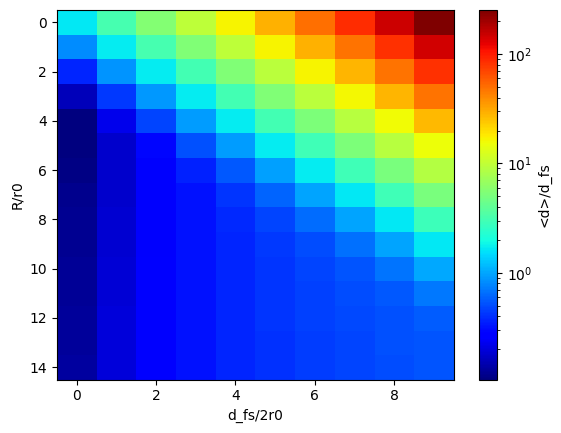

In [11]:
f, a = plt.subplots()
im = a.imshow(avg_d_n, cmap='jet', aspect='auto', norm=LogNorm(), interpolation='nearest')
a.set_xlabel('d_fs/2r0')
a.set_ylabel('R/r0')
f.colorbar(im, label='<d>/d_fs')

In [12]:
theory_fun = lambda x : 8 / (2 * 2 * np.pi) * x ** 2
fit_vis_x = np.linspace(1, alpha_map.max(), 10)
fit_vis_y = theory_fun(fit_vis_x)

theory_3d = 0.556

In [154]:
beta_list

array([ 1.73780083,  2.27977623,  2.99077983,  3.92352718,  5.14717444,
        6.75244583,  8.85836009, 11.62105488, 15.24536315, 20.        ])

In [14]:
size_legend_values = beta_list[::2] * 2

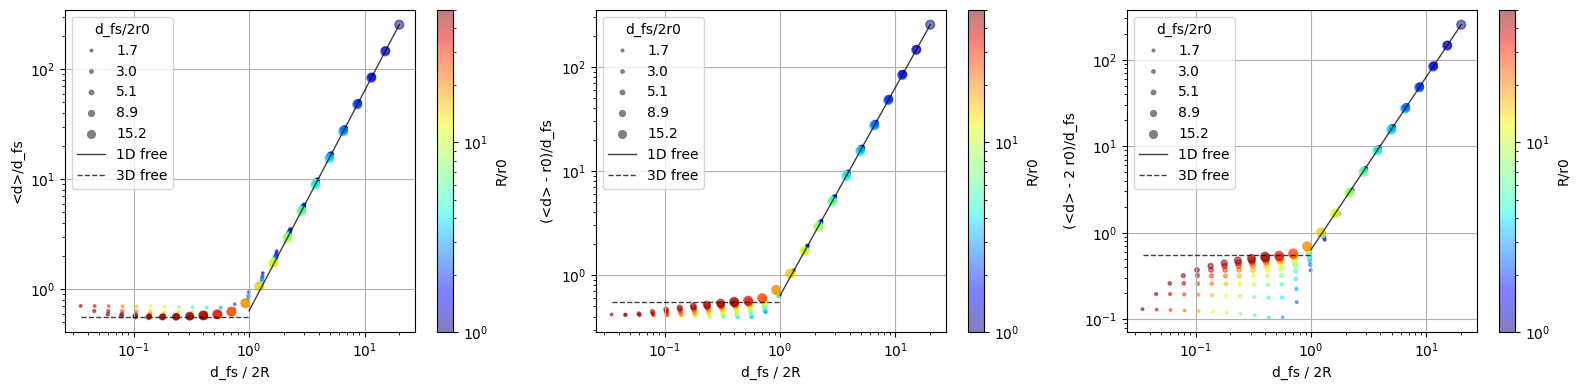

In [17]:
f, a = plt.subplots(1, 3, figsize=(16, 4))
for i in range(3):
    avg_d_n = (avg_d - i * R_sphere) / d_fs_map[None, :]
    # (x, y, sz, color)
    sc = a[i].scatter(alpha_map.flatten(), avg_d_n.flatten(), 2 * beta_map.flatten(), gamma_map.flatten(), alpha=0.5, cmap='jet', norm=LogNorm())
    th_1d,  = a[i].plot(fit_vis_x, fit_vis_y, linewidth=1, alpha=0.75, label=f"1D free", color='k')
    th_3d = a[i].hlines(theory_3d, alpha_map.min(), 1, colors='k', linestyles='--', linewidth=1, alpha=0.75, label='3D free')
    legend_handles = [Line2D([0], [0], marker='o', color='w', label=f"{size / 2:.1f}", markerfacecolor='gray', markeredgecolor='gray', markersize=(size**0.5))  # sqrt to match scatter's sizing
        for size in size_legend_values]
    legend_handles += [th_1d, th_3d]
    labels = [h.get_label() for h in legend_handles]
    a[i].legend(legend_handles, labels, title='d_fs/2r0')
    a[i].set_yscale('log')
    a[i].set_xscale('log')
    a[i].set_xlabel('d_fs / 2R')
    if i == 0: 
        y_label = '<d>/d_fs'
    elif i == 1: 
        y_label = '(<d> - r0)/d_fs'
    else: 
        y_label = f'(<d> - {i} r0)/d_fs'
    a[i].set_ylabel(y_label)
    a[i].grid()
    f.colorbar(sc, label='R/r0')
    # a[i].set_title(f"Marker size ~ d_fs / 2r0")
f.tight_layout()

In [18]:
fp = os.path.join(vis_folder, f"Hard_sphere_r0_{R_sphere}_d2dfs_vs_alpha.png")
io.print_image_in_several_formats(f, fp)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/simulation/Hard_sphere_r0_2_d2dfs_vs_alpha.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/simulation/Hard_sphere_r0_2_d2dfs_vs_alpha.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Zhang2020/visualization/simulation/Hard_sphere_r0_2_d2dfs_vs_alpha.png


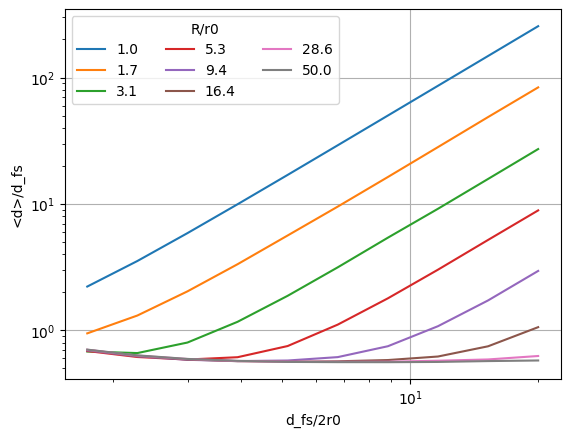

In [73]:
f, a = plt.subplots()
for i in range(0, gamma_list.size, 2): 
    a.plot(beta_list, avg_d_n[i], label=f"{gamma_list[i]:.1f}")
a.set_xscale('log')
a.set_yscale('log')
a.set_xlabel('d_fs/2r0')
a.set_ylabel('<d>/d_fs')
a.grid()
a.legend(title='R/r0', ncol=3)